# Mid-term project

# Authors:
# Kashish Hundia & John Zhang

# Project Title:
# Quantitative Analysis of Financial Indicators in S&P 500 Constituent Equities

# Primary Objective:


*   This project aims to discover how various financial metrics are correlated and interpret the correlation. For instance, how the use of debt by companies can positively contribute to higher net income, and how operating profitability influences asset pricing.
*   We then move on to analyze the investability of different sectors in the US.


*   Finally, we write a filter that select equities that are ready to be invested in given a strict criteria.

# Step 1: Scrape S&P 500 companies
A Wikipedia page displays the current S&P 500 constituents. We try to read in the html file and scrap the first four columns which contains Symbol, Security, GICS Sector, and GICS Sub-Industry. However, access was innitially blocked so we added a header to mimics a real web brower to be able to access the website.

In [ ]:
import pandas as pd
import requests

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

headers = {"User-Agent": "Mozilla/5.0"}

# Fetch the page and read table
df = pd.read_html(requests.get(url, headers=headers).text)[0]

# Keep the first four columns
df = df[["Symbol", "Security", "GICS Sector", "GICS Sub-Industry"]]
df

/tmp/ipython-input-1566802506.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(requests.get(url, headers=headers).text)[0]


,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services
...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment


In [ ]:
df.head(80)

,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services
...,...,...,...,...
75,BF.B,Brown–Forman,Consumer Staples,Distillers & Vintners
76,BLDR,Builders FirstSource,Industrials,Building Products
77,BG,Bunge Global,Consumer Staples,Agricultural Products & Services
78,BXP,"BXP, Inc.",Real Estate,Office REITs


# Step 2: Data cleaning for compatibility with yfinance API

The stock symbols scraped from Wikipedia can contain a “.”, but in yfinance, these symbols are represented using a “-”. For instance, "BF.B" is displayed as "BF-B" in yfinance. To make them compatible, we replace every “.” with “-” and store the result in a new column in Cleaned_Symbol. This updated dataset is saved in a new DataFrame named clean_df, which is essentially the original df with the added Cleaned_Symbol column.

In [ ]:
# Clean ticker symbols for yfinance (replace . with -)
cleaned_df = df.copy()
cleaned_df['Cleaned_Symbol'] = cleaned_df['Symbol'].str.replace('.', '-', regex=False)

# List of tickers for yfinance
tickers = cleaned_df['Cleaned_Symbol'].tolist()
display(cleaned_df)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Cleaned_Symbol
0,MMM,3M,Industrials,Industrial Conglomerates,MMM
1,AOS,A. O. Smith,Industrials,Building Products,AOS
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,ABT
3,ABBV,AbbVie,Health Care,Biotechnology,ABBV
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,ACN
...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,XYL
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,YUM
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,ZBRA
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,ZBH


# Step 3: Install and import yfinance

In [ ]:

!pip install yfinance --quiet

import yfinance as yf
import time

# Step 4: Download fundamental indicators



*   We download dozens of fundamental indicators covering market data, valuation, profitability, growth  debt, cashflow, and dividend metrics from yfinance using the method "info.get()" for each single S&P constituent stored in "tickers", which we created in the previous step.
*   We then store the data in a new, empty dictionary named "all_stock_data".
*   We then convert this dictionary into a dataframe for readability and later analytical purposes.



In [ ]:
all_stock_data = {}

# We use try-except here because .info may return incomplete data and .get() may return missing metrics.
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        stock_data = {
            # Market Data
            'Price': info.get('currentPrice'),
            '52_week_high': info.get('fiftyTwoWeekHigh'),
            '52_week_low': info.get('fiftyTwoWeekLow'),
            'marketCap': info.get('marketCap'),

            # Valuation
            'PE': info.get('trailingPE'),
            'PE_forward': info.get('forwardPE'),
            'PEG_ratio': info.get('pegRatio'),
            'P/B': info.get('priceToBook'),
            'price_to_sales': info.get('priceToSalesTrailing12Months'),
            'ev_to_ebitda': info.get('enterpriseToEbitda'),

            # Profitability
            'EPS_TTM': info.get('trailingEps'),
            'EBITDA': info.get('ebitda'),
            'profit_margin': info.get('profitMargins'),
            'operating_margin': info.get('operatingMargins'),
            'return_on_equity': info.get('returnOnEquity'),
            'return_on_assets': info.get('returnOnAssets'),

            # Growth Metrics
            'revenue_growth': info.get('revenueGrowth'),
            'earnings_growth': info.get('earningsGrowth'),

            # Debt & Risk
            'Debt_to_equity': info.get('debtToEquity'),
            'Beta': info.get('beta'),
            'current_ratio': info.get('currentRatio'),

            # Cash Flow
            'operating_cash_flow': info.get('operatingCashFlow'),
            'free_cash_flow': info.get('freeCashFlow'),

            # Dividends
            'DividendYield': info.get('dividendYield'),

            # Company Info
            'Sector': info.get('sector'),
            'Industry': info.get('industry')
        }
        all_stock_data[ticker] = stock_data
        time.sleep(0.1)  # we use time.sleep() to delay runtime to avoid blocking
    except Exception as e:
        print(f"Failed for {ticker}: {e}")


# Convert to DataFrame

if all_stock_data:
    fundamentals_df = pd.DataFrame.from_dict(all_stock_data, orient='index')
    fundamentals_df.reset_index(inplace=True)
    fundamentals_df.rename(columns={'index': 'ticker'}, inplace=True)
else:
    print(" no data")
    fundamentals_df = pd.DataFrame()  # empty fallback

display(fundamentals_df.head())

,ticker,Price,52_week_high,52_week_low,marketCap,PE,PE_forward,PEG_ratio,P/B,price_to_sales,...,revenue_growth,earnings_growth,Debt_to_equity,Beta,current_ratio,operating_cash_flow,free_cash_flow,DividendYield,Sector,Industry
0,MMM,171.60,171.629,121.98,91158224896,27.368422,21.721520,None,19.696970,3.672033,...,0.035,-0.375,281.904,1.108,1.842,None,None,1.75,Industrials,Conglomerates
1,AOS,69.04,78.250,58.83,9556837376,19.231200,16.963144,None,5.241023,2.521460,...,-0.013,0.009,18.035,1.303,1.647,None,None,2.02,Industrials,Specialty Industrial Machinery
2,ABT,126.34,141.230,110.86,222691721216,15.871859,24.484497,None,4.348604,5.079299,...,0.069,-0.000,26.501,0.696,NaN,None,None,1.87,Healthcare,Medical Devices
3,ABBV,228.25,244.810,163.81,403216924672,108.690480,18.816982,None,-2194.711400,6.912922,...,0.066,-0.324,NaN,0.507,0.736,None,None,2.87,Healthcare,Drug Manufacturers - General
4,ACN,249.81,398.350,229.40,154916896768,20.543585,17.754797,None,4.979767,2.223486,...,0.073,-0.155,25.380,1.278,1.420,None,None,2.61,Technology,Information Technology Services


In [ ]:
fundamentals_df.head(50)

,ticker,Price,52_week_high,52_week_low,marketCap,PE,PE_forward,PEG_ratio,P/B,price_to_sales,...,revenue_growth,earnings_growth,Debt_to_equity,Beta,current_ratio,operating_cash_flow,free_cash_flow,DividendYield,Sector,Industry
0,MMM,171.60,171.629,121.98,91158224896,27.368422,21.721520,None,19.696970,3.672033,...,0.035,-0.375,281.904,1.108,1.842,None,None,1.75,Industrials,Conglomerates
1,AOS,69.04,78.250,58.83,9556837376,19.231200,16.963144,None,5.241023,2.521460,...,-0.013,0.009,18.035,1.303,1.647,None,None,2.02,Industrials,Specialty Industrial Machinery
2,ABT,126.34,141.230,110.86,222691721216,15.871859,24.484497,None,4.348604,5.079299,...,0.069,-0.000,26.501,0.696,NaN,None,None,1.87,Healthcare,Medical Devices
3,ABBV,228.25,244.810,163.81,403216924672,108.690480,18.816982,None,-2194.711400,6.912922,...,0.066,-0.324,NaN,0.507,0.736,None,None,2.87,Healthcare,Drug Manufacturers - General
4,ACN,249.81,398.350,229.40,154916896768,20.543585,17.754797,None,4.979767,2.223486,...,0.073,-0.155,25.380,1.278,1.420,None,None,2.61,Technology,Information Technology Services
5,ADBE,354.12,557.900,327.50,148234633216,22.077305,17.232117,None,12.636312,6.394660,...,0.107,0.112,56.542,1.490,1.019,None,None,NaN,Technology,Software - Application
6,AMD,234.99,242.880,76.48,381352050688,139.875020,46.076473,None,6.388202,12.883515,...,0.317,2.336,6.513,1.894,2.491,None,None,NaN,Technology,Semiconductors
7,AES,14.20,17.370,9.46,10175187968,10.923078,6.995074,None,3.000845,0.845677,...,-0.030,NaN,313.243,0.924,0.823,None,None,4.96,Utilities,Utilities - Diversified
8,AFL,107.55,115.430,96.95,57681580032,24.222973,15.000000,None,2.114670,3.625492,...,-0.190,-0.642,55.055,0.849,1.219,None,None,2.16,Financial Services,Insurance - Life
9,A,147.46,153.840,96.43,41804972032,34.453270,26.099115,None,6.564866,6.158658,...,0.101,0.216,56.421,1.262,2.248,None,None,0.67,Healthcare,Diagnostics & Research


# Step 5: Allign company information with their respective metrics

*   Here, we create an comprehensive dataframe that store previous company information with metrics for that company for all constituents

In [ ]:
# Step 5: Merge with S&P 500 metadata

if not fundamentals_df.empty:
    final_df = fundamentals_df.merge(
        cleaned_df[['Cleaned_Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']],
        left_on='ticker',
        right_on='Cleaned_Symbol',
        how='left'
    )

    # Drop duplicate column
    final_df = final_df.drop('Cleaned_Symbol', axis=1)
    display(final_df.head())

,ticker,Price,52_week_high,52_week_low,marketCap,PE,PE_forward,PEG_ratio,P/B,price_to_sales,...,Beta,current_ratio,operating_cash_flow,free_cash_flow,DividendYield,Sector,Industry,Security,GICS Sector,GICS Sub-Industry
0,MMM,171.60,171.629,121.98,91158224896,27.368422,21.721520,None,19.696970,3.672033,...,1.108,1.842,None,None,1.75,Industrials,Conglomerates,3M,Industrials,Industrial Conglomerates
1,AOS,69.04,78.250,58.83,9556837376,19.231200,16.963144,None,5.241023,2.521460,...,1.303,1.647,None,None,2.02,Industrials,Specialty Industrial Machinery,A. O. Smith,Industrials,Building Products
2,ABT,126.34,141.230,110.86,222691721216,15.871859,24.484497,None,4.348604,5.079299,...,0.696,NaN,None,None,1.87,Healthcare,Medical Devices,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,228.25,244.810,163.81,403216924672,108.690480,18.816982,None,-2194.711400,6.912922,...,0.507,0.736,None,None,2.87,Healthcare,Drug Manufacturers - General,AbbVie,Health Care,Biotechnology
4,ACN,249.81,398.350,229.40,154916896768,20.543585,17.754797,None,4.979767,2.223486,...,1.278,1.420,None,None,2.61,Technology,Information Technology Services,Accenture,Information Technology,IT Consulting & Other Services


# Step 6: Derive a few more metrics


*  We want to find more a few more metrics but these aren't provided by yfinance anymore so we directly calculate them from already existing columns in final_df. We just directly create new columns and store those calculations.

In [ ]:
# Volatility (52-week range)
final_df['Volatility'] = (final_df['52_week_high'] - final_df['52_week_low']) / final_df['52_week_low']

# Bollinger Band Width (volatility based)
final_df['Bollinger_Band_Width'] = final_df['Volatility'] * 2

display(final_df.head(10))

,ticker,Price,52_week_high,52_week_low,marketCap,PE,PE_forward,PEG_ratio,P/B,price_to_sales,...,operating_cash_flow,free_cash_flow,DividendYield,Sector,Industry,Security,GICS Sector,GICS Sub-Industry,Volatility,Bollinger_Band_Width
0,MMM,171.60,171.629,121.98,91158224896,27.368422,21.721520,None,19.696970,3.672033,...,None,None,1.75,Industrials,Conglomerates,3M,Industrials,Industrial Conglomerates,0.407026,0.814051
1,AOS,69.04,78.250,58.83,9556837376,19.231200,16.963144,None,5.241023,2.521460,...,None,None,2.02,Industrials,Specialty Industrial Machinery,A. O. Smith,Industrials,Building Products,0.330104,0.660207
2,ABT,126.34,141.230,110.86,222691721216,15.871859,24.484497,None,4.348604,5.079299,...,None,None,1.87,Healthcare,Medical Devices,Abbott Laboratories,Health Care,Health Care Equipment,0.273949,0.547898
3,ABBV,228.25,244.810,163.81,403216924672,108.690480,18.816982,None,-2194.711400,6.912922,...,None,None,2.87,Healthcare,Drug Manufacturers - General,AbbVie,Health Care,Biotechnology,0.494475,0.988951
4,ACN,249.81,398.350,229.40,154916896768,20.543585,17.754797,None,4.979767,2.223486,...,None,None,2.61,Technology,Information Technology Services,Accenture,Information Technology,IT Consulting & Other Services,0.736486,1.472973
5,ADBE,354.12,557.900,327.50,148234633216,22.077305,17.232117,None,12.636312,6.394660,...,None,None,NaN,Technology,Software - Application,Adobe Inc.,Information Technology,Application Software,0.703511,1.407023
6,AMD,234.99,242.880,76.48,381352050688,139.875020,46.076473,None,6.388202,12.883515,...,None,None,NaN,Technology,Semiconductors,Advanced Micro Devices,Information Technology,Semiconductors,2.175732,4.351464
7,AES,14.20,17.370,9.46,10175187968,10.923078,6.995074,None,3.000845,0.845677,...,None,None,4.96,Utilities,Utilities - Diversified,AES Corporation,Utilities,Independent Power Producers & Energy Traders,0.836152,1.672304
8,AFL,107.55,115.430,96.95,57681580032,24.222973,15.000000,None,2.114670,3.625492,...,None,None,2.16,Financial Services,Insurance - Life,Aflac,Financials,Life & Health Insurance,0.190614,0.381227
9,A,147.46,153.840,96.43,41804972032,34.453270,26.099115,None,6.564866,6.158658,...,None,None,0.67,Healthcare,Diagnostics & Research,Agilent Technologies,Health Care,Life Sciences Tools & Services,0.595354,1.190708


# Part 2: Visualization and analysis

# Step 1: Comprehensive correlation matrix overview


*   We create a heatmap that takes in all numerical values from final_df to analyze correlations between all of them.


*   First thing first, we use "select_dtypes(include=['float64', 'int64']).columns" to locate only numeric columns and store to "correlation_data"



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

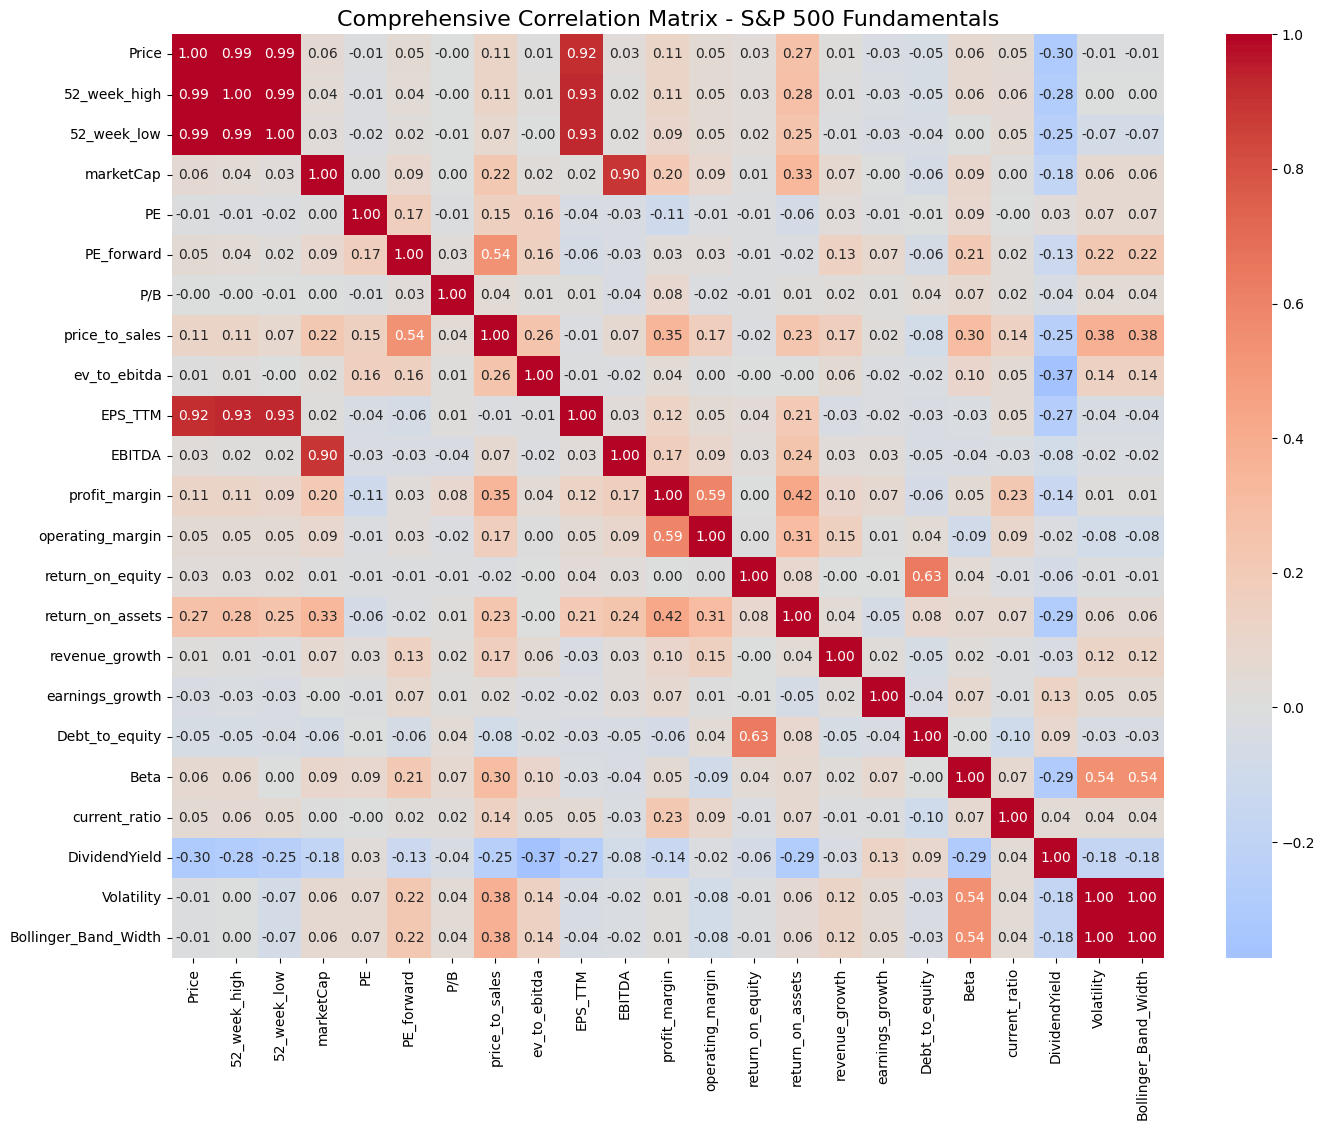

In [ ]:
# Comprehensive correlation matrix for final_df

# Select only numeric columns for correlation
numeric_cols = final_df.select_dtypes(include=['float64', 'int64']).columns
correlation_data = final_df[numeric_cols]

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Create heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Comprehensive Correlation Matrix - S&P 500 Fundamentals', fontsize=16)
plt

# Discovery 1:
We found that there is a quite high correlation between debt to equity and return on equity

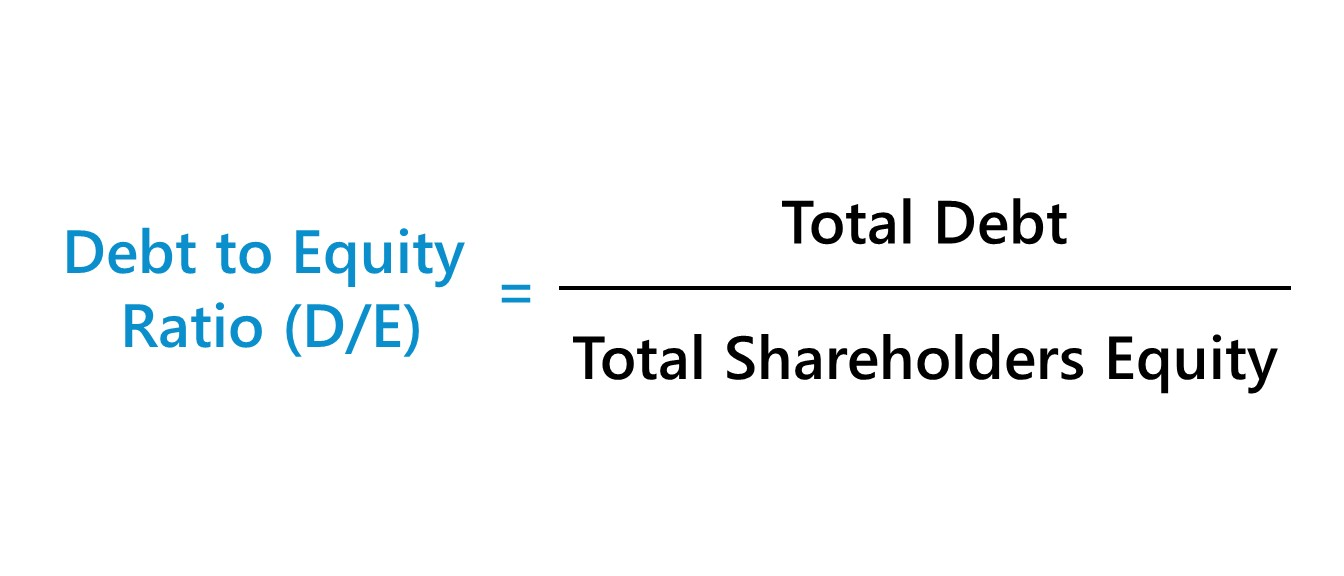

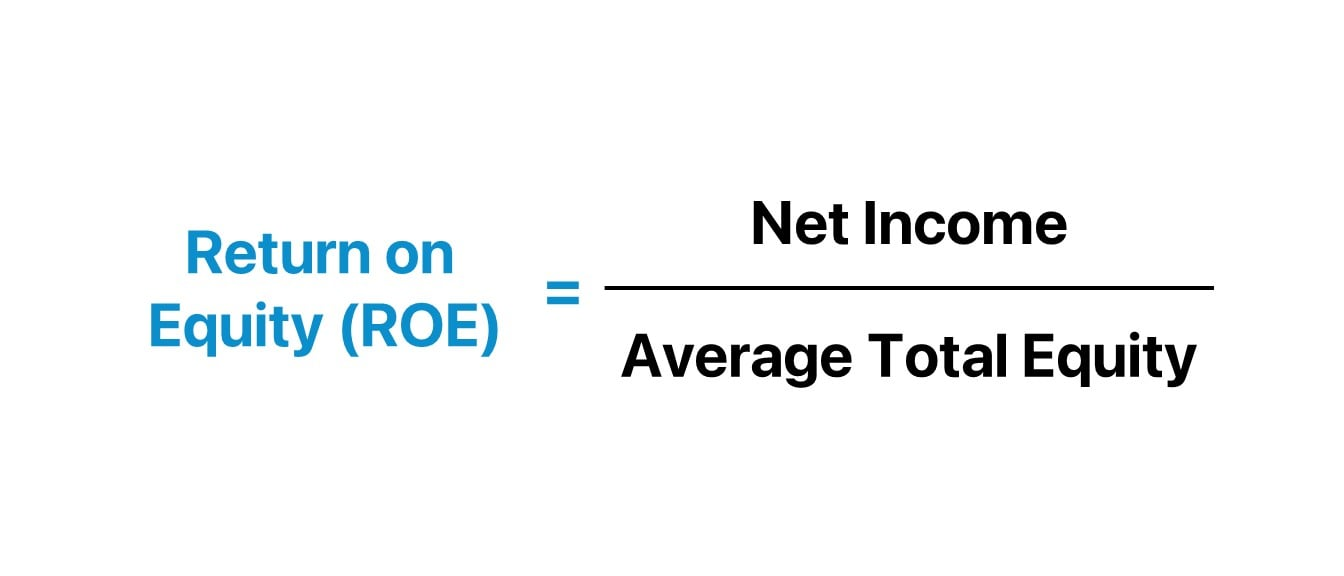

# Interpretation:
Both indicators have equity as their denomenators, so the correlation can be analyzed through the numerators directly. The correlation indicate that, in general, higher debt, in other words, more use of levearge, generate more income.

# Visualization


*   We wish to visualize our first discovery using a scatter plot.
*   Firstly, we assign the metrics of interest to the axes


*   There exist extreme outliers so we narrowed done the ROE range to 0 - 4 and D/E to <1000
*   We use the formula ".corr" to find Pearson's correlation coefficient. The coefficient may slightly differ because we changed the data range to exclude outliers as aforementioned.





Correlation: 0.547


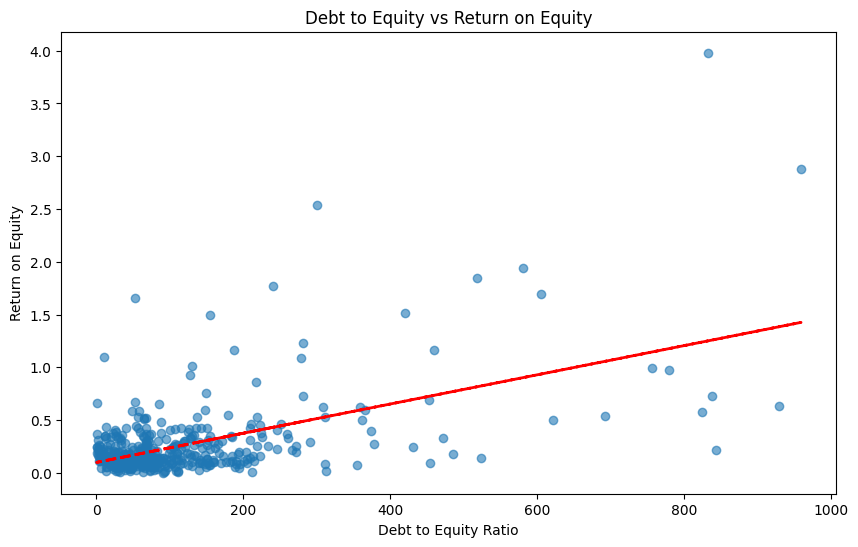

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter data to exclude outliers
filtered_data = fundamentals_df[
    (fundamentals_df['return_on_equity'] >= 0) &
    (fundamentals_df['return_on_equity'] <= 4) &
    (fundamentals_df['Debt_to_equity'] < 1000)
]

x = filtered_data['Debt_to_equity']
y = filtered_data['return_on_equity']

# Calculate correlation and line of best fit
correlation = x.corr(y)
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, line, "r--", linewidth=2)
plt.xlabel('Debt to Equity Ratio')
plt.ylabel('Return on Equity')
plt.title('Debt to Equity vs Return on Equity')

plt

print(f"Correlation: {correlation:.3f}")

# Discovery 2: high correlation between EBITDA & Market Capitalization

# Interpretation:

EBITDA is the ultimate measure of a firm's operating profitability since non-operational elements such as income taxes, depreciation & amortization are excluded.
Market cap reflects the collective market judgment of that company's worth.

In financial valuation, an equity is valuated based on how much cash it will generate in the future. In our case, higher profitability reflected by high EBITDA shows more cashflow in the future, and thus investors think it's worth more, and thus market cap is higher as a result.

# Visualization

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

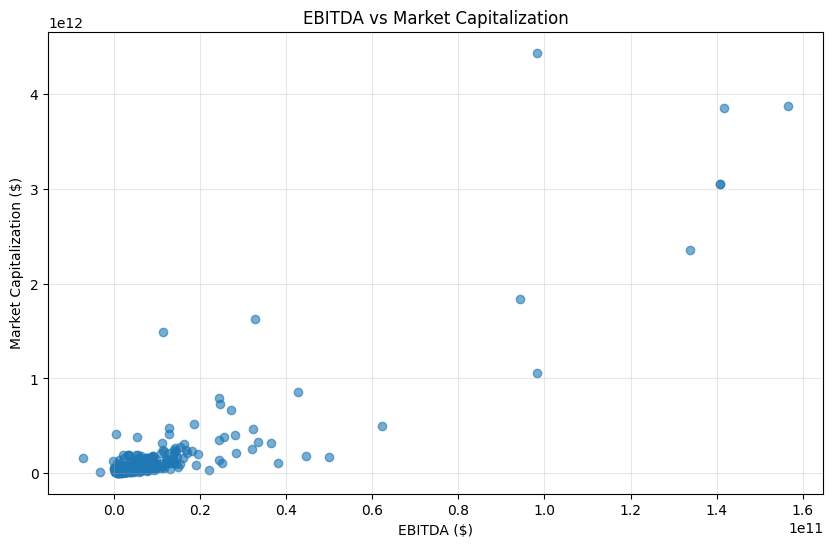

In [ ]:
# Correlation plot between EBITDA and Market Cap
plt.figure(figsize=(10, 6))
plt.scatter(final_df['EBITDA'], final_df['marketCap'], alpha=0.6)
plt.xlabel('EBITDA ($)')
plt.ylabel('Market Capitalization ($)')
plt.title('EBITDA vs Market Capitalization')
plt.grid(True, alpha=0.3)

# Calculate and display correlation
correlation = final_df['EBITDA'].corr(final_df['marketCap'])
plt

# Question: Which sectors are the most profitable?

# Here, we use six different profitability & performance indicators do analyze different sectors' in s&p 500 constituent equities.

SECTOR PROFITABILITY ANALYSIS


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

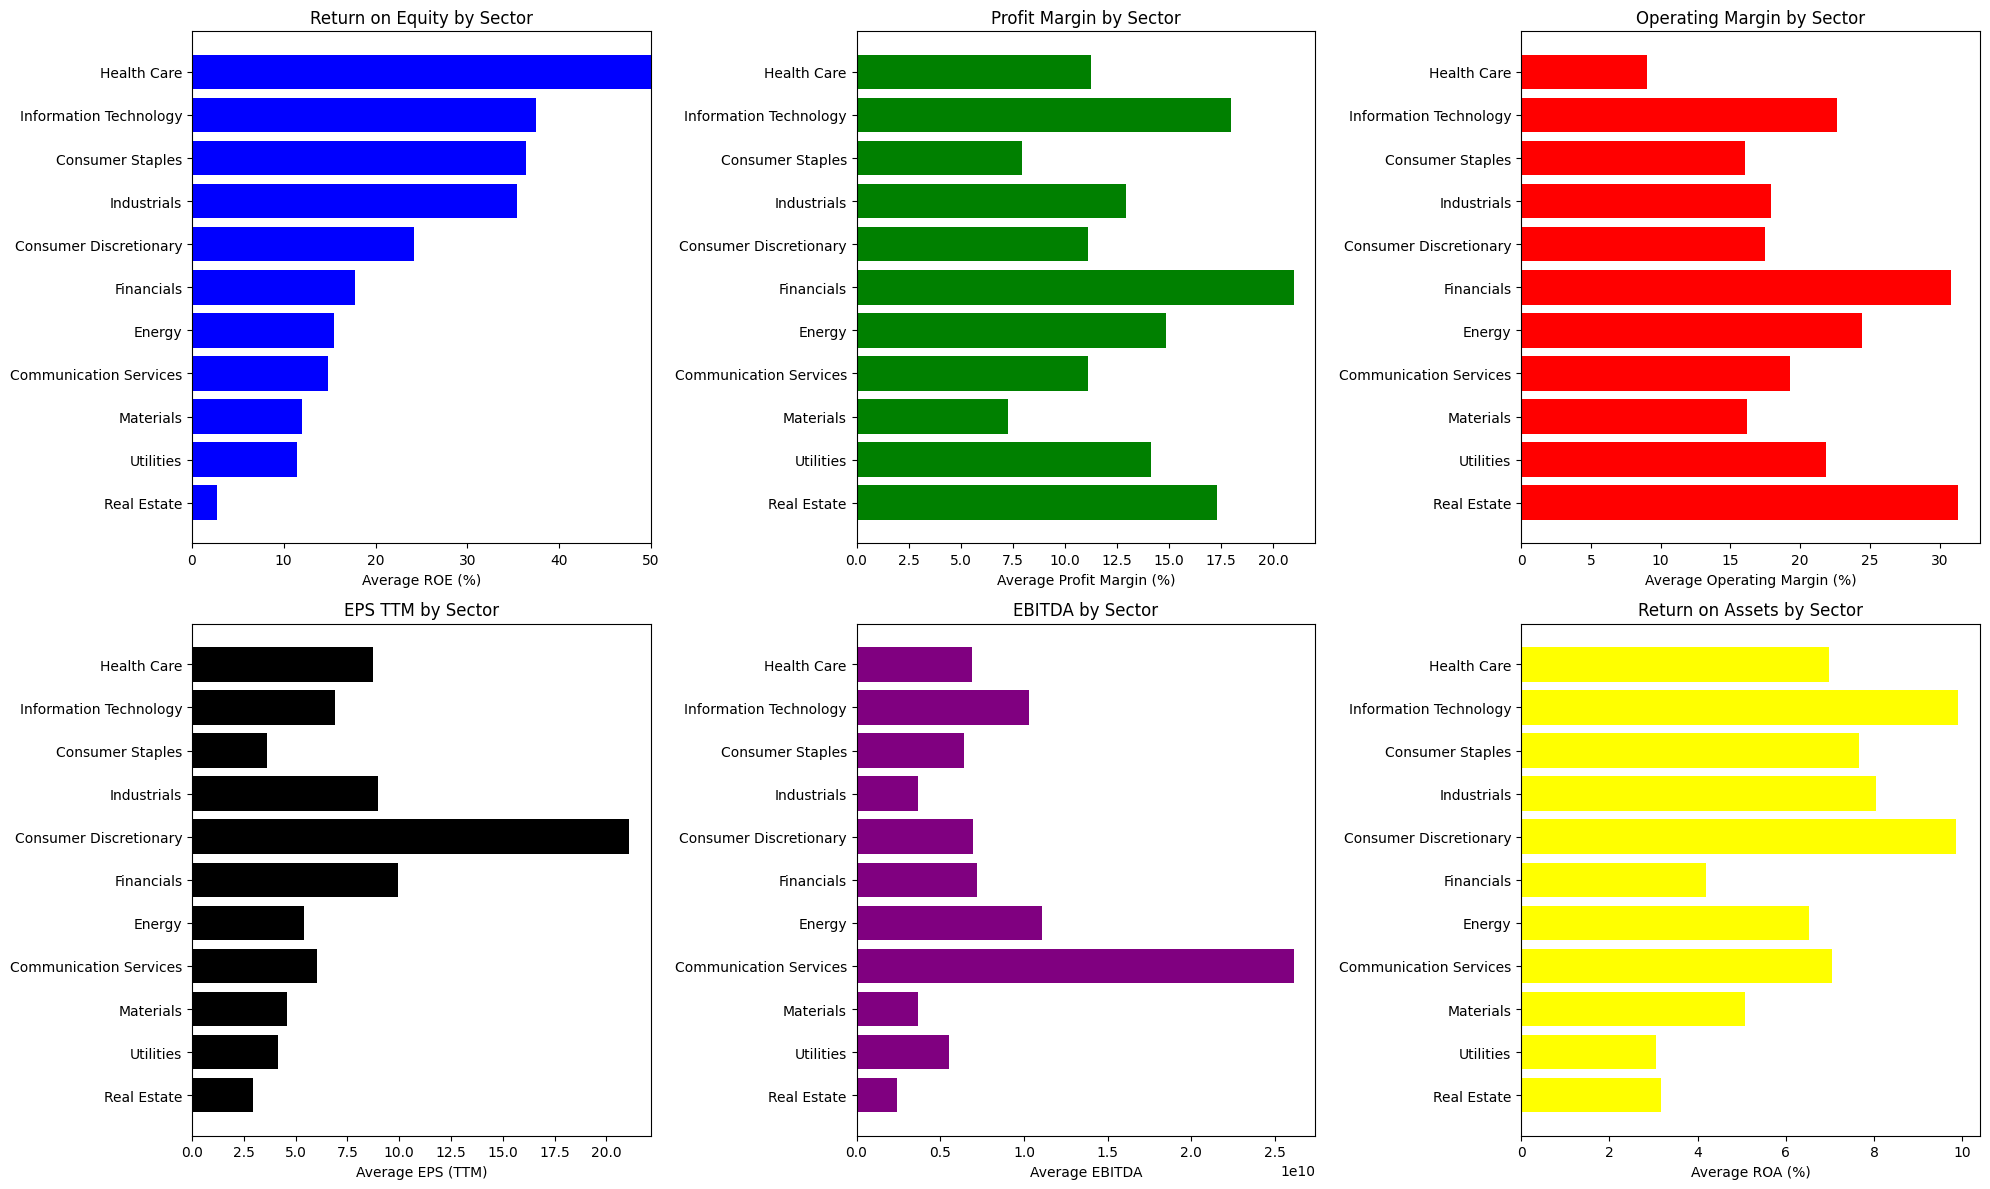

In [ ]:
# Profitability & Performance Analysis
print("SECTOR PROFITABILITY ANALYSIS")

# Calculate average profitability metrics by sector
sector_profitability = final_df.groupby('GICS Sector').agg({
    'return_on_equity': 'mean',
    'profit_margin': 'mean',
    'operating_margin': 'mean',
    'EPS_TTM': 'mean',
    'EBITDA': 'mean',
    'return_on_assets': 'mean'
})

sector_profitability = sector_profitability.sort_values('return_on_equity', ascending=False)

# Convert to percentages for better readability (where applicable)
sector_profitability_pct = sector_profitability.copy()
sector_profitability_pct[['return_on_equity', 'profit_margin', 'operating_margin', 'return_on_assets']] = sector_profitability_pct[['return_on_equity', 'profit_margin', 'operating_margin', 'return_on_assets']] * 100

# Create six simple bar graphs
plt.figure(figsize=(20, 12))

# Graph 1: Return on Equity by Sector
plt.subplot(2, 3, 1)
plt.barh(sector_profitability_pct.index, sector_profitability_pct['return_on_equity'], color='blue')
plt.xlabel('Average ROE (%)')
plt.title('Return on Equity by Sector')
plt.xlim(0, 50)  # Added this line to limit x-axis range
plt.gca().invert_yaxis()

# Graph 2: Profit Margin by Sector
plt.subplot(2, 3, 2)
plt.barh(sector_profitability_pct.index, sector_profitability_pct['profit_margin'], color='green')
plt.xlabel('Average Profit Margin (%)')
plt.title('Profit Margin by Sector')
plt.gca().invert_yaxis()

# Graph 3: Operating Margin by Sector
plt.subplot(2, 3, 3)
plt.barh(sector_profitability_pct.index, sector_profitability_pct['operating_margin'], color='red')
plt.xlabel('Average Operating Margin (%)')
plt.title('Operating Margin by Sector')
plt.gca().invert_yaxis()

# Graph 4: EPS TTM by Sector
plt.subplot(2, 3, 4)
plt.barh(sector_profitability.index, sector_profitability['EPS_TTM'], color='black')
plt.xlabel('Average EPS (TTM)')
plt.title('EPS TTM by Sector')
plt.gca().invert_yaxis()

# Graph 5: EBITDA by Sector
plt.subplot(2, 3, 5)
plt.barh(sector_profitability.index, sector_profitability['EBITDA'], color='purple')
plt.xlabel('Average EBITDA')
plt.title('EBITDA by Sector')
plt.gca().invert_yaxis()

# Graph 6: Return on Assets by Sector
plt.subplot(2, 3, 6)
plt.barh(sector_profitability_pct.index, sector_profitability_pct['return_on_assets'], color='yellow')
plt.xlabel('Average ROA (%)')
plt.title('Return on Assets by Sector')
plt.gca().invert_yaxis()

plt.tight_layout()
plt


# Discoveries:
1, The difference in ROE (≈17%) and ROA (≈4%) in the Financials sector are significant. This is due to the fact that financial institutiosn use high leverage in their business model. The use of debt to fund assets is a key characteristic of the financial sector.

2, The real estate sector has relatively high profit margin and operating margin but low ROE, ROI, EPS_TTM, and EBITDA.

# Question: Valuation by sectors

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

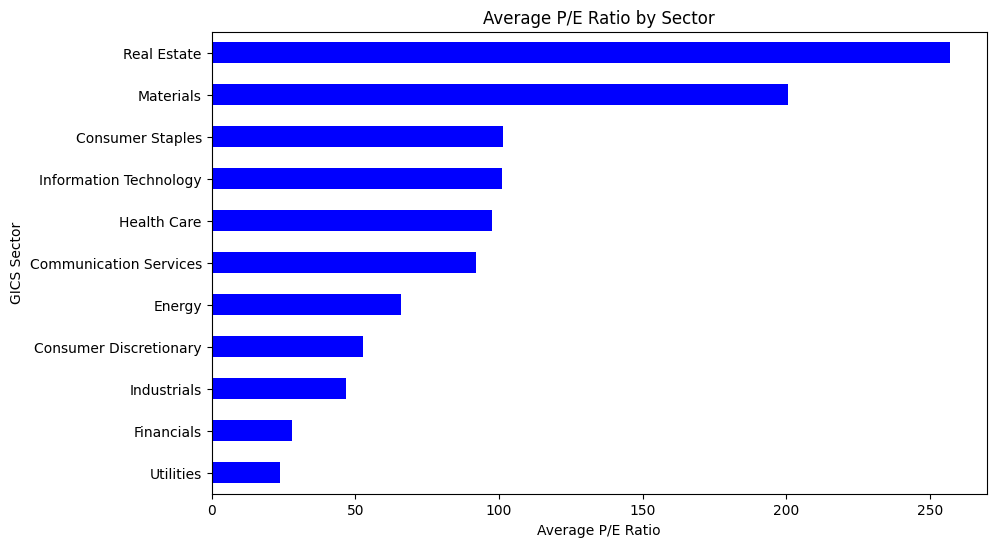

In [ ]:
# Which sectors are most/least expensive? (PE ratios by GICS Sector)

# Calculate average PE by sector
sector_pe = final_df.groupby('GICS Sector')['PE'].mean().sort_values(ascending=False)

# Bar chart of PE ratios by sector
plt.figure(figsize=(10, 6))
sector_pe.plot(kind='barh', color='blue')
plt.title('Average P/E Ratio by Sector')
plt.xlabel('Average P/E Ratio')
plt.gca().invert_yaxis()
plt

# Experiment: We apply an filter to find high quality, financially healthy, and fairly valued companies that meet our metrics criteria

In [ ]:
import pandas as pd

# Investment filter
stocks_df = final_df[
    (final_df['return_on_equity'] > 0.08) &
    (final_df['Debt_to_equity'] < 2.0) &
    (final_df['PE'] > 0) & (final_df['PE'] < 30) &
    (final_df['profit_margin'] > 0.05)
].copy()

# Sort and display
stocks_df = stocks_df.sort_values('return_on_equity', ascending=False)

display(stocks_df[['ticker', 'Security', 'PE', 'return_on_equity', 'Debt_to_equity', 'profit_margin']])

,ticker,Security,PE,return_on_equity,Debt_to_equity,profit_margin
323,MPWR,Monolithic Power Systems,28.009418,0.66500,0.585,0.73167
176,ERIE,Erie Indemnity,27.277220,0.31144,1.609,0.15728
246,INCY,Incyte,21.113474,0.24299,1.017,0.18994
123,CPRT,Copart,28.094337,0.18481,1.127,0.33408


#Another filter

In [ ]:
# Step 8: Filter top stocks
top_stocks = final_df[
    (final_df['return_on_equity'] > 0.15) &       # Stricter ROE criterium
    (final_df['PE'] < 25) &                       # More undervaluation
    (final_df['Debt_to_equity'] < 100)            # Manageable debt
].sort_values(by='return_on_equity', ascending=False)

display(top_stocks[['ticker','Security','PE','return_on_equity','Debt_to_equity','Price']].head(20))
for i, row in top_stocks.head(5).iterrows():
    print(f"Stock: {row['Security']} ({row['ticker']})")
    print(f"  PE ratio = {row['PE']} --> Lower PE may indicate undervaluation compared to earnings")
    print(f"  ROE = {row['return_on_equity']*100:.1f}% --> Higher ROE means company efficiently generates profits")
    print(f"  Debt to Equity = {row['Debt_to_equity']} --> Reasonable leverage reduces financial risk\n")

,ticker,Security,PE,return_on_equity,Debt_to_equity,Price
457,UBER,Uber,16.117548,0.67485,52.230,94.61
30,AMP,Ameriprise Financial,14.904924,0.58239,57.793,478.15
5,ADBE,Adobe Inc.,22.077305,0.52875,56.542,354.12
479,GWW,W. W. Grainger,24.468780,0.52412,66.838,964.07
492,WSM,"Williams-Sonoma, Inc.",20.915462,0.51219,64.858,188.03
459,ULTA,Ulta Beauty,20.118143,0.48521,87.863,524.48
387,QCOM,Qualcomm,16.412163,0.44615,54.350,170.03
140,DECK,Deckers Brands,15.751152,0.43579,12.647,102.54
295,LULU,Lululemon Athletica,12.222526,0.42422,40.178,179.06
185,EXPD,Expeditors International,19.357843,0.39038,26.694,118.47


Stock: Uber (UBER)
  PE ratio = 16.117548 --> Lower PE may indicate undervaluation compared to earnings
  ROE = 67.5% --> Higher ROE means company efficiently generates profits
  Debt to Equity = 52.23 --> Reasonable leverage reduces financial risk

Stock: Ameriprise Financial (AMP)
  PE ratio = 14.904924 --> Lower PE may indicate undervaluation compared to earnings
  ROE = 58.2% --> Higher ROE means company efficiently generates profits
  Debt to Equity = 57.793 --> Reasonable leverage reduces financial risk

Stock: Adobe Inc. (ADBE)
  PE ratio = 22.077305 --> Lower PE may indicate undervaluation compared to earnings
  ROE = 52.9% --> Higher ROE means company efficiently generates profits
  Debt to Equity = 56.542 --> Reasonable leverage reduces financial risk

Stock: W. W. Grainger (GWW)
  PE ratio = 24.46878 --> Lower PE may indicate undervaluation compared to earnings
  ROE = 52.4% --> Higher ROE means company efficiently generates profits
  Debt to Equity = 66.838 --> Reasonable l

# Visualization: Debt to Equity by Sector

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

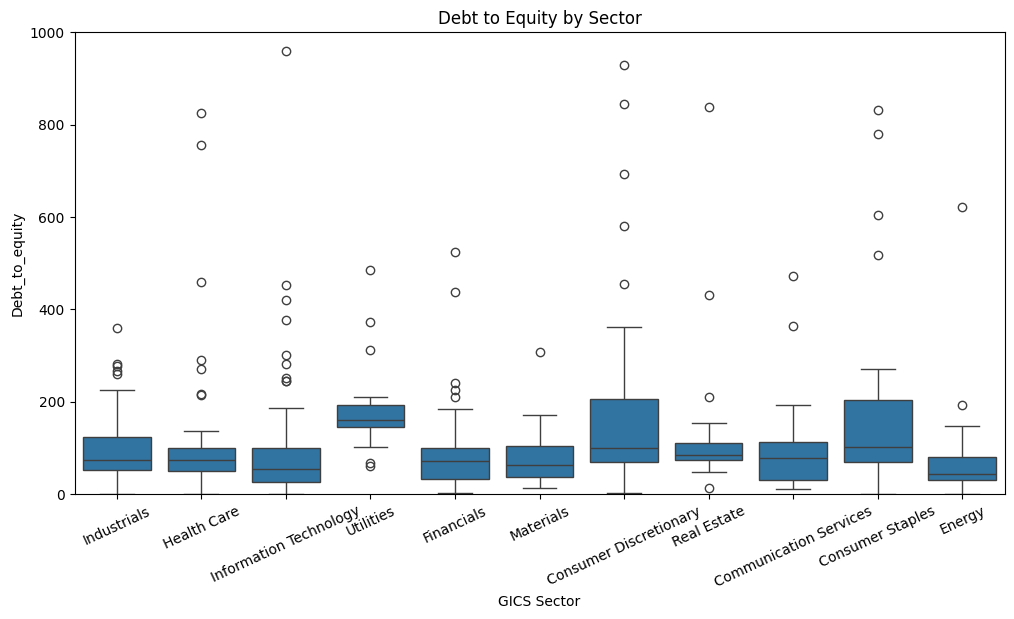

In [ ]:
plt.figure(figsize=(12,6))
clean_debt_data = final_df.dropna(subset=['Debt_to_equity'])
sns.boxplot(data=clean_debt_data, x='GICS Sector', y='Debt_to_equity')
plt.xticks(rotation=25)
plt.title('Debt to Equity by Sector')
plt.ylim(0, 1000)
plt

# Interpretation:


*   Different sectors have different business models. In capital budgeting, companies in different sectors may prefer debt/ the issuance of bonds or equity, contributing to difference in debt to equity ratio.
*   Utilities have a the highest median, indicating a preference for debt over equity for capital financing.

# **Writeup:**
Link:

docs.google.com/document/d/1lYCZWvP4bxLqlwK1IQAwmXHTZe886Yrs/edit?usp=sharing&ouid=101413055214030598754&rtpof=true&sd=true